In [1]:
import pandas as pd
from futils import ROOT
full_df_filtered = pd.read_feather(ROOT / "data/gnina_processed/LIT-PCBA/filtered.feather")
n_df = pd.read_csv(ROOT / "data/raw_data/LIT-PCBA/AVE_unbiased/n.csv", index_col = 0)
from os.path import join
import rdkit.Chem as Chem
SDF = Chem.SDMolSupplier
import os

In [3]:
full_df = pd.read_feather(ROOT / "data/gnina_processed/LIT-PCBA/full.feather")

In [4]:
sort_according_to = "CNNaffinity"

In [15]:
full_df_filtered_affinity = full_df.sort_values(sort_according_to, ascending = False).drop_duplicates(["_Name", "directory", "ligands"])
full_df_filtered_affinity["active_groundtruth"] = full_df_filtered_affinity["ligands"].str.contains("_active_")
# full_df_filtered.reset_index().rename(columns = {"level_0": "unfiltered_index"}).to_feather(join(inputdir, "filtered.feather"))

In [73]:
def get_subset(df, dir):
    return df[df["directory"] == dir]
def get_data(df):
    dirs = df["directory"].unique()
    output_data = {}
    for dir in dirs:
        subset = get_subset(df, dir)
        one_percent = int(len(subset)*0.01)+1
        top1 = subset.iloc[:one_percent]
        n_true_actives, n_true_total = n_df.loc[dir]
        normalizer = (min(one_percent, n_true_actives) / one_percent) / (n_true_actives / n_true_total)
        ef1 = (top1["active_groundtruth"].sum()/len(top1)) / (n_true_actives / n_true_total)

        output_data[dir] = dict(EF1 = ef1,
                                NEF1 = ef1/normalizer,
                                n_actives_found = top1["active_groundtruth"].sum(),
                                length = one_percent,
                                gt_active_proportion = (n_true_actives / n_true_total),
                                total_succeeded = len(subset),
                                total_ligands = n_true_total
                                )
    out_df = pd.DataFrame(output_data).T.astype({"length": int, "n_actives_found": int, "total_succeeded": int, "total_ligands": int})
    out_df.rename(columns = {"length": r"1% is equal to"}, inplace = True)
    return out_df

In [74]:
get_subset(full_df_filtered, "VDR")

,unfiltered_index,index,_Name,_MolFileInfo,_MolFileComments,minimizedAffinity,minimizedRMSD,CNNscore,CNNaffinity,CNN_VS,CNNaffinity_variance,directory,ligands,protein,active_groundtruth
0,6496240,86252,17508466,,,-11.27799,3.01144,0.968660,8.394079,8.131010,0.095767,VDR,AID504847_inactive_T,3a2j_protein,False
1,6511841,101853,862222,,,-10.17719,2.46820,0.969409,8.151896,7.902517,0.090637,VDR,AID504847_inactive_T,3a2j_protein,False
4,6311617,34777,49826589,,,-10.51209,2.26413,0.961290,8.078357,7.765646,0.043513,VDR,AID504847_inactive_V,3a2j_protein,False
5,6730909,121154,85267233,,,-11.38583,3.60472,0.930751,8.326475,7.749871,0.091699,VDR,AID504847_inactive_T,3a2i_protein,False
6,6548805,138817,24780019,,,-11.95625,2.42978,0.922204,8.392721,7.739801,0.040293,VDR,AID504847_inactive_T,3a2j_protein,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2595258,6418412,8424,24838300,,,29.71631,4.82714,0.004860,6.335969,0.030795,0.196962,VDR,AID504847_inactive_T,3a2j_protein,False
2595384,6405897,62483,85146878,,,80.29423,1.41382,0.005095,5.516238,0.028107,1.303834,VDR,AID504847_inactive_V,3a2i_protein,False
2595644,6528453,118465,26732160,,,38.92920,1.20503,0.004193,5.546630,0.023257,0.426948,VDR,AID504847_inactive_T,3a2j_protein,False
2596217,6321423,44583,92763408,,,60.25909,0.83740,0.002254,5.405281,0.012184,0.509071,VDR,AID504847_inactive_V,3a2j_protein,False


In [75]:
VS = get_data(full_df_filtered).sort_index()
VS.index.name = "target"
VS

,EF1,NEF1,n_actives_found,1% is equal to,gt_active_proportion,total_succeeded,total_ligands
target,,,,,,,
ADRB2,11.768472,0.117647,2,3124,0.000054,312319,312500
ALDH1,1.321291,0.065257,71,1088,0.049389,108700,108850
ESR1_ago,7.686813,0.076923,1,56,0.002323,5595,5596
ESR1_ant,10.678585,0.215686,11,51,0.020198,5049,5050
FEN1,2.440197,0.024390,9,3556,0.001037,355552,355771
GBA,3.617120,0.036145,6,2960,0.000560,295973,296218
IDH1,2.565435,0.025641,1,3619,0.000108,361872,362088
KAT2A,1.547466,0.015464,3,3485,0.000556,348486,348742
MAPK1,2.923797,0.029221,9,629,0.004894,62815,62937


In [76]:
VS.total_ligands - VS.total_succeeded

target
ADRB2         181
ALDH1         150
ESR1_ago        1
ESR1_ant        1
FEN1          219
GBA           245
IDH1          216
KAT2A         256
MAPK1         122
MTORC1         26
OPRK1       84669
PKM2          168
PPARG           1
TP53            0
VDR           202
dtype: int64

In [22]:
VS.reset_index().rename(columns = {"index": "target"})

,target,EF1,NEF1,n_actives_found,1% is equal to,gt_active_proportion,total_succeeded,total_ligands
0,ADRB2,13.337431,0.133333,2,3124,0.000048,312319,312496
1,ALDH1,1.321735,0.065257,71,1088,0.049373,108700,108846
2,ESR1_ago,9.077922,0.090909,1,56,0.001967,5595,5592
3,ESR1_ant,10.883529,0.215686,11,51,0.019818,5049,5046
4,FEN1,2.453468,0.024523,9,3556,0.001032,355552,355767
5,GBA,3.661182,0.036585,6,2960,0.000554,295973,296214
6,IDH1,2.704077,0.027027,1,3619,0.000102,361872,362084
7,KAT2A,1.563567,0.015625,3,3485,0.000551,348486,348738
8,MAPK1,2.942720,0.029412,9,629,0.004862,62815,62933
9,MTORC1,2.103037,0.021053,2,331,0.002873,33043,33065


In [89]:
((269836/100)**-1)/0.000082

4.519456985435417

In [86]:
get_subset(full_df_filtered, "OPRK1")["ligands"].value_counts()

AID1777_inactive_T    117727
AID1777_inactive_V     67420
AID1777_active_T          18
AID1777_active_V           6
Name: ligands, dtype: int64

In [41]:
tp53 = get_subset(full_df_filtered, "TP53")

In [8]:
print(len(Chem.SDMolSupplier("../../data/equibind_processed/LIT-PCBA/OPRK1/AID1777_inactive_T/6b73_protein/output.sdf")))
print(len(Chem.SDMolSupplier("../../data/equibind_processed/LIT-PCBA/OPRK1/AID1777_inactive_V/6b73_protein/output.sdf")))
print(len(Chem.SDMolSupplier("../../data/equibind_processed/LIT-PCBA/OPRK1/AID1777_active_V/6b73_protein/output.sdf")))
print(len(Chem.SDMolSupplier("../../data/equibind_processed/LIT-PCBA/OPRK1/AID1777_active_T/6b73_protein/output.sdf")))


202224
67420
6
18


In [15]:
sup = SDF("/home/qzj517/POR-DD/data/gnina_processed/LIT-PCBA/OPRK1/AID1777_inactive_T/6b73_protein/chopped/124394.sdf", sanitize = False)

In [12]:
orgsup = SDF("/home/qzj517/POR-DD/data/equibind_processed/LIT-PCBA/OPRK1/AID1777_inactive_T/6b73_protein/output.sdf", sanitize = False)

In [14]:
allnames = {mol.GetProp("_Name"): i for i, mol in enumerate(orgsup) if mol}

In [ ]:
allmols = [mol for mol in orgsup]

In [17]:
idx = [allnames[mol.GetProp("_Name")] for mol in sup if mol]

[10:39:43] ERROR: EOF hit while reading bonds
[10:39:43] ERROR: moving to the beginning of the next molecule


In [19]:
idx[-1]

117574

In [57]:
print(orgsup.GetItemText(faulty_index))

17514570
     RDKit          3D

 45 49  0  0  0  0  0  0  0  0999 V2000
   53.9236  -16.0954   -8.3626 Cl  0  0  0  0  0  0  0  0  0  0  0  0
   54.7924  -17.4774   -7.8135 C   0  0  0  0  0  0  0  0  0  0  0  0
   55.7411  -17.3757   -6.8657 C   0  0  0  0  0  0  0  0  0  0  0  0
   56.3647  -18.5817   -6.3374 C   0  0  0  0  0  0  0  0  0  0  0  0
   55.8817  -19.8008   -6.6613 C   0  0  0  0  0  0  0  0  0  0  0  0
   55.0066  -19.8891   -7.8328 C   0  0  0  0  0  0  0  0  0  0  0  0
   54.4139  -18.7842   -8.3245 C   0  0  0  0  0  0  0  0  0  0  0  0
   56.0497  -20.9576   -5.9078 N   0  0  0  0  0  0  0  0  0  0  0  0
   55.7485  -22.1847   -6.4766 N   0  0  0  0  0  0  0  0  0  0  0  0
   56.5248  -23.0025   -5.8270 C   0  0  0  0  0  0  0  0  0  0  0  0
   56.4522  -24.4868   -5.8103 C   0  0  0  0  0  0  0  0  0  0  0  0
   57.3779  -24.9820   -4.3123 S   0  0  0  0  0  0  0  0  0  0  0  0
   57.8790  -23.2960   -3.7983 C   0  0  0  0  0  0  0  0  0  0  0  0
   57.4831  -22.3

In [58]:
offset = 200
with open("/home/qzj517/POR-DD/data/equibind_processed/LIT-PCBA/OPRK1/AID1777_inactive_T/6b73_protein/finding_corrupt/idk.sdf", "w") as f:
    for i in range(10):
        f.write(orgsup.GetItemText(idx[-1]+i+offset))

In [52]:
faulty_index = idx[-1]+offset

In [53]:
faulty_index

117774

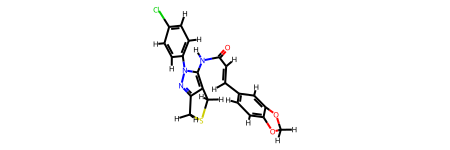

In [55]:
orgsup[faulty_index]

In [37]:
len(Chem.SDMolSupplier("../../data/gnina_processed/LIT-PCBA/OPRK1/AID1777_inactive_T/6b73_protein/gnina_out.sdf"))
# print(len(Chem.SDMolSupplier("../../data/gnina_processed/LIT-PCBA/OPRK1/AID1777_inactive_V/6b73_protein/gnina_out.sdf")))
# print(len(Chem.SDMolSupplier("../../data/gnina_processed/LIT-PCBA/OPRK1/AID1777_active_V/6b73_protein/gnina_out.sdf")))
# print(len(Chem.SDMolSupplier("../../data/gnina_processed/LIT-PCBA/OPRK1/AID1777_active_T/6b73_protein/gnina_out.sdf")))


117629

In [14]:
x1 = len(Chem.SDMolSupplier("/home/qzj517/POR-DD/data/equibind_processed/LIT-PCBA/OPRK1/AID1777_inactive_T/6b73_protein/chopped/12592.sdf"))
x2 = len(Chem.SDMolSupplier("/home/qzj517/POR-DD/data/equibind_processed/LIT-PCBA/OPRK1/AID1777_inactive_T/6b73_protein/chopped/24768.sdf"))
x3 = len(Chem.SDMolSupplier("/home/qzj517/POR-DD/data/equibind_processed/LIT-PCBA/OPRK1/AID1777_inactive_T/6b73_protein/chopped/38118.sdf"))
print(x1)
print(x1+x2)
print(x1+x2+x3)

12593
24769
38119


In [41]:
sup = Chem.SDMolSupplier("../../data/gnina_processed/LIT-PCBA/OPRK1/AID1777_inactive_T/6b73_protein/gnina_out.sdf", sanitize = False)
sup2 = Chem.SDMolSupplier("../../data/equibind_processed/LIT-PCBA/OPRK1/AID1777_inactive_T/6b73_protein/output.sdf", sanitize = False)

In [42]:
gnina_names = [mol.GetProp("_Name") for mol in sup if mol]
eq_names = [mol.GetProp("_Name") for mol in sup2 if mol]

[11:36:28] ERROR: EOF hit while reading atoms
[11:36:28] ERROR: moving to the beginning of the next molecule


In [43]:
namedict = {name: i for i, name in enumerate(eq_names)}

In [44]:
found = []
for name in gnina_names:
    found.append(namedict[name])

In [57]:
837448//2*1000

418724000

In [26]:
names

['51090821',
 '51090809',
 '51090805',
 '51090803',
 '51090798',
 '51090792',
 '51090791',
 '51090788',
 '51090787',
 '51090786',
 '51090785',
 '51090784',
 '51090783',
 '51090782',
 '51090781',
 '51090779',
 '51090778',
 '51090777',
 '51090769',
 '51090767',
 '51090766',
 '51090764',
 '51090763',
 '51090748',
 '51090730',
 '51090728',
 '51090722',
 '51090721',
 '51090716',
 '51090710',
 '51090701',
 '51090700',
 '51090697',
 '51090693',
 '51090689',
 '51090682',
 '51090672',
 '51090660',
 '51090658',
 '51090657',
 '51090655',
 '51090654',
 '51090650',
 '51090648',
 '51090637',
 '51090630',
 '51090627',
 '51090626',
 '51090618',
 '51090611',
 '51090610',
 '51090609',
 '51090607',
 '51090606',
 '51090605',
 '51090603',
 '51090601',
 '51090581',
 '51090567',
 '51090565',
 '51090564',
 '51090563',
 '51090560',
 '51090558',
 '51090554',
 '51090552',
 '51090551',
 '51090543',
 '51090537',
 '51090534',
 '51090483',
 '51090477',
 '51090473',
 '51090471',
 '51090468',
 '51090467',
 '51090463',

In [102]:
def get_names(protname):
    dirname = "../../data/raw_data/LIT-PCBA/AVE_unbiased"
    smiles_files = [join(dirname, protname, file) for file in os.listdir(join(dirname, protname)) if file.endswith(".smi")]
    names = {}
    for smiles_file in smiles_files:
        names[smiles_file] = []
        sup = Chem.SmilesMolSupplier(smiles_file, titleLine=False)
        for mol in sup:
            names[smiles_file].append(mol.GetProp("_Name"))
    return names

In [103]:
data = get_names("OPRK1")

In [104]:
list(map(len, data.values()))

[202362, 67454, 6, 18]

In [60]:
next(it)

'144208296'

In [43]:
tp53._Name

27065      144206283
31769      144205429
45090      144208592
47914      144210983
50870      144205056
             ...    
2422525    144204233
2461545    144206991
2499799    144205124
2501217    144208858
2594543    144204648
Name: _Name, Length: 4247, dtype: object

In [28]:
print(VS["EF1"].median())


2.4534677545415815


In [30]:
print(VS["NEF1"].mean())


0.05120386624677328


In [260]:
out_df["total_ligands"] - out_df["total_succeeded"]

VDR           198
MAPK1         118
ESR1_ago       -3
ESR1_ant       -3
ADRB2         177
ALDH1         146
PKM2          164
MTORC1         22
IDH1          151
OPRK1       84665
PPARG          -3
KAT2A         252
FEN1          215
TP53           -4
dtype: int64